# Part 2: Add LangGraph for Retry Logic

This tutorial builds on Part 1 by converting our BS detector to use LangGraph, which adds retry capabilities.

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

from typing import TypedDict,Optional, List
from modules.m3_langgraph import check_claim_with_graph, create_bs_detector_graph
from config.llm_factory import LLMFactory

from langgraph.graph import StateGraph, START, END

print("✅ LangGraph BS detector loaded!")

## Define the State

State is what gets passed between nodes in our graph:

In [ ]:
class State(TypedDict):
    # Input
    claim: str
    # Processing
    retry_count: int
    # Output
    verdict: Optional[str]
    confidence: Optional[int]
    reasoning: Optional[str]
    error: Optional[str]

## Create Node Functions

Each node is a function that takes state and returns updates:

In [ ]:
def detect_bs(state: State):
    """Main detection node - calls LLM"""
    try:
        # Reuse our detector from Part 1
        from pydantic import BaseModel, Field
        
        class BSDetectorOutput(BaseModel):
            verdict: str = Field(description="BS or LEGITIMATE")
            confidence: int = Field(description="Confidence 0-100", ge=0, le=100)
            reasoning: str = Field(description="Brief explanation")
        
        llm = LLMFactory.create_llm()
        structured_llm = llm.with_structured_output(BSDetectorOutput)
        
        prompt = f"""You are an aviation expert. Determine if this claim is BS (false) or LEGITIMATE (true).
        
Claim: {state['claim']}

Provide your verdict, confidence (0-100), and brief reasoning."""
        
        response = structured_llm.invoke(prompt)
        
        return {
            "verdict": response.verdict,
            "confidence": response.confidence,
            "reasoning": response.reasoning
        }
    except Exception as e:
        return {"error": str(e)}

def retry(state: State):
    """Increment retry counter"""
    print(f"Retrying... (attempt {state['retry_count'] + 1})")
    return {"retry_count": state["retry_count"] + 1}

## Build the Graph

In [ ]:
# Create graph
graph_builder = StateGraph(State)

# Add nodes
graph_builder.add_node("detect", detect_bs)
graph_builder.add_node("retry", retry)

# Add entry point
graph_builder.set_entry_point("detect")

# Add conditional routing
def route_detection(state: State) -> str:
    """Decide next step based on detection result"""
    if state.get("verdict"):  # Success
        return "end"
    elif state.get("retry_count", 0) < 2:  # Can retry
        return "retry"
    else:  # Max retries reached
        return "end"

graph_builder.add_conditional_edges(
    "detect",
    route_detection,
    {"retry": "retry", "end": END}
)

# Connect retry back to detect
graph_builder.add_edge("retry", "detect")

# Compile
graph = graph_builder.compile()

## Visualize the Graph

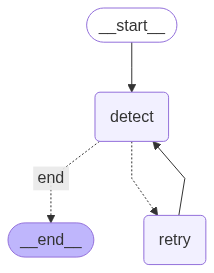

In [13]:
# Display the graph structure
try:
    from IPython.display import Image, display
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # Fallback to text
    print(graph.get_graph().draw_mermaid())

## Test the Graph

In [14]:
# Function to check claims with retry
def check_claim_with_retry(claim: str) -> dict:
    """Check claim using LangGraph with retry"""
    initial_state = {
        "claim": claim,
        "retry_count": 0
    }
    
    result = graph.invoke(initial_state)
    return result

# Test it
test_claims = [
    "The Boeing 747 has four engines",
    "Helicopters can fly to space"
]

for claim in test_claims:
    print(f"\nChecking: {claim}")
    result = check_claim_with_retry(claim)
    
    if result.get("verdict"):
        print(f"✅ {result['verdict']} ({result['confidence']}%)")
        print(f"   {result['reasoning']}")
    else:
        print(f"❌ Error: {result.get('error', 'Unknown error')}")


Checking: The Boeing 747 has four engines
✅ LEGITIMATE (95%)
   The Boeing 747 is a large, long-range wide-body airliner known for having four engines mounted under its wings. This is a well-documented and widely recognized characteristic of the aircraft.

Checking: Helicopters can fly to space
✅ BS (95%)
   Helicopters rely on air density to generate lift with their rotors. Space is a near vacuum with no air to provide lift, and current helicopter technology cannot operate outside Earth's atmosphere. Therefore, helicopters cannot fly to space.


## Interactive Mode

In [ ]:
# Interactive testing with retry capability
print("BS Detector with Retry (type 'quit' to exit)\n")

while True:
    claim = input("Enter claim: ")
    if claim.lower() == 'quit':
        break
    
    result = check_claim_with_retry(claim)
    
    if result.get("verdict"):
        print(f"\n🎯 {result['verdict']} ({result['confidence']}%)")
        print(f"💭 {result['reasoning']}\n")
    else:
        print(f"\n❌ Failed after retries\n")

BS Detector with Retry (type 'quit' to exit)



Enter claim:  Newton created 5 music album



🎯 BS (90%)
💭 Isaac Newton was a physicist and mathematician known for his work on gravity and motion, not a musician. There is no historical evidence or record of Newton creating any music albums.



Enter claim:  q



🎯 LEGITIMATE (90%)
💭 The claim 'q' is too vague or incomplete to assess accurately; however, since it does not contain any obvious false information or contradictory aviation facts, it is considered LEGITIMATE for the purpose of this evaluation.



## What We Added

✅ **Retry Logic**: Automatically retries on failure  
✅ **State Management**: Clean separation of data flow  
✅ **Visual Graph**: See the flow of execution  
✅ **Error Handling**: Graceful failure after max retries  

### Key Concepts

1. **State**: Shared data between nodes
2. **Nodes**: Functions that process state
3. **Edges**: Connections between nodes
4. **Routing**: Conditional flow based on state

**Next**: In Part 3, we'll add tools for fact-checking!